In [2]:
##-------------------------------------------------------------------------------
## TOY MODEL OF HOT JUPITER TIDAL DISRUPTION FROM STELLAR TIDES

## This code reproduces Section 2, Figure 2 of Millholland, MacLeod, Xiao (2025)

import numpy as np
from numpy import cos, sin, pi, sqrt, exp
import os
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt
import scipy 
from scipy import stats


G = 6.67408*10**(-11)   # gravitational constant 
Mearth = 5.9722*10**24  # kg
Rearth = 6.371*10**6  # meters
Msun = 1.98911*10**30 # kg
Rsun = 6.95*10**8 # meters
Mjup = 1.898*10**27  # kg
Rjup = 7.1492*10**7 # meters
year = 365.25*24*60*60  # years in seconds
AU = 149597870700 # meters



In [3]:
##--------------------------------------------------
## TIDAL DECAY FUNCTIONS

def a_dot_func(a, t, Mstar, Rstar, Qstar_prime, Mp):
    # Jackson et al. (2009) equation 1 (e = 0)
    # INPUTS
    # Mstar, Rstar in Solar units
    # Mp in Jupiter masses
    # a in AU
    # OUTPUTS
    # da/dt in AU/year
    if a < 0.005:
        return 0
    else:
        Mstar = Mstar*Msun
        Rstar = Rstar*Rsun
        Mp = Mp*Mjup
        a = a*AU
        a_dot = -(9./2)*(G/Mstar)**(0.5)*(Rstar**5*Mp/Qstar_prime)*a**(-11./2)   # m/s
        a_dot = a_dot*(year/AU)  # AU/year
        return (a_dot)
    
    
def a_func(a_0, t_now, t_birth, Mstar, Rstar, Qstar_prime, Mp):
    # Obtained by solving the da/dt equation for a
    # INPUTS
    # Mstar, Rstar in Solar units
    # Mp in Jupiter masses
    # a in AU
    # t_now, t_birth in Gyr
    # OUTPUTS
    # a in AU at time t_now 
    adot_0 = a_dot_func(a_0, 0, Mstar, Rstar, Qstar_prime, Mp)
    tau_0 = -a_0/adot_0
    tau_decay_0 = ((2./13)*tau_0)/(1e9)
    t_decay = t_birth + tau_decay_0
    a_now = a_0*((t_decay - t_now)/(t_decay - t_birth))**(2./13)  # result is in AU
    return a_now


def linear_fit_function(t_distribution, N_bins, time_threshold_low = 0.01, time_threshold_high = 1, bin_count_threshold = 1, bin_range = (-4.5, 2.5), normalized = False):
    # This function performs a linear fit of the t_distribution for times in the
    # range time_threshold_low to time_threshold_high 
    
    # t_distribution has shape (N_planets, N_times)
    N_planets, N_times = t_distribution.shape
    
    # Calculate histogram for each time
    counts_all = np.zeros((N_times, N_bins))
    for i in range(N_times):
        counts_all[i], bin_edges = np.histogram(np.log10(t_distribution[:,i]), range = bin_range, density = normalized, bins = N_bins)
            
    log10_counts = np.log10(counts_all[-1])    

    # Take the bins within the thresholds
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    indices = np.where((bin_centers > np.log10(time_threshold_low)) & (bin_centers < np.log10(time_threshold_high)) & \
                       (~np.isinf(log10_counts)) & (log10_counts > np.log10(bin_count_threshold)))[0]

    # Perform linear fit
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bin_centers[indices], log10_counts[indices])
    p_fit = np.array([slope, intercept])
        
    # Return linear fit parameters (slope, y-int)
    return (p_fit, r_value, np.sum(counts[indices]))


In [4]:
##---------------------------------------------
## SIMULATED HOT JUPITER POPULATION

## Start systems at different ages and different semi-major axes.
## Explore the evolution of the decay timescale distribution in discrete times.


## PARAMETER RANGES
Mstar_min = 0.7  # min stellar mass, solar masses
Mstar_max = 2.0  # max stellar mass, solar masses
log10_Qstar_prime_min =  6.0  # min stellar quality factor
log10_Qstar_prime_max = 8.0   # max stellar quality factor 
Mp_min = 0.5   # min planet mass, Jupiter masses
Mp_max = 2.0   # max planet mass, Jupiter massses
Rp_min = 0.8   # min planet radius, Jupiter radii
Rp_max = 2.0   # min planet radius, Jupiter radii
a_min = 0.01  # min semi-major axis, AU
a_max = 0.1   # max semi-major axis, AU
age_min = 0  # min age, Gyr
age_max = 8.0  # max age, Gyr  
t_Univ = 13.7  # age of the Universe, Gyr
t_birth_min = t_Univ - age_max  # birth time
t_birth_max = t_Univ - age_min
# times to plot the distribution
t_min = 7.0  # Gyr
t_max = 13.0   # Gyr


N_planets_2 = 200000
N_bins = 70
bin_range = (-4.5, 2.5)


time_step_2 = 1  # 1 Gyr
N_times_2 = int((t_max - t_min)/time_step_2)
t_arr = np.linspace(t_min, t_max, N_times_2+1)
a_evolve_arr_2 = np.zeros((N_planets_2, N_times_2+1))
tau_decay_0_evolve_arr_2 = np.zeros((N_planets_2, N_times_2+1))
tau_decay_evolve_arr_2 = np.zeros((N_planets_2, N_times_2+1))

# set parameters
Mstar_arr = np.random.uniform(Mstar_min, Mstar_max, N_planets_2)
Rstar_arr = Mstar_arr
Qstar_prime_arr = 10**np.random.uniform(log10_Qstar_prime_min, log10_Qstar_prime_max, N_planets_2)
Mp_arr = np.random.uniform(Mp_min, Mp_max, N_planets_2)
Rp_arr = np.random.uniform(Rp_min, Rp_max, N_planets_2)
a_0_arr_2 = np.random.uniform(a_min, a_max, N_planets_2)
t_birth_arr_2 = np.random.uniform(t_birth_min, t_birth_max, N_planets_2)
adot_0_arr_2 = np.array([a_dot_func(a_0_arr_2[i], 0, Mstar_arr[i], Rstar_arr[i], Qstar_prime_arr[i], Mp_arr[i]) for i in range(N_planets_2)])
tau_0_arr_2 = -a_0_arr_2/adot_0_arr_2 
tau_decay_0_arr_2 = ((2./13)*tau_0_arr_2)/(1e9)  # decay time from birth in Gyr
t_decay_arr_2 = t_birth_arr_2 + tau_decay_0_arr_2  # time of decay in Gyr


## LOOP THROUGH PLANETS
## Calculate which planets still exist as a function of time
## Approximate the decay as instantaneous from a_0 to 0 
for i in range(N_planets_2):
    # Calculate where planets are not yet "born"
    indices_prebirth = np.where(t_arr < t_birth_arr_2[i])[0]
    a_evolve_arr_2[i][indices_prebirth] = np.nan
    tau_decay_0_evolve_arr_2[i][indices_prebirth] = np.nan
    tau_decay_evolve_arr_2[i][indices_prebirth] = np.nan

    # Calculate where planets are "dead"
    indices_prebirth = np.where(t_arr > t_decay_arr_2[i])[0]
    a_evolve_arr_2[i][indices_prebirth] = np.nan
    tau_decay_0_evolve_arr_2[i][indices_prebirth] = np.nan
    tau_decay_evolve_arr_2[i][indices_prebirth] = np.nan

    # Calculate where planets are born and still "alive"  
    indices_alive = np.where((t_arr > t_birth_arr_2[i]) & (t_arr < t_decay_arr_2[i]))[0]
    if len(indices_alive) == 0:
        continue
    else:
        for j in range(len(indices_alive)):
            time_index = indices_alive[j]
            a_now = a_func(a_0_arr_2[i], t_arr[time_index], t_birth_arr_2[i], Mstar_arr[i], Rstar_arr[i], Qstar_prime_arr[i], Mp_arr[i])
            a_dot_now = a_dot_func(a_now, t_arr[time_index], Mstar_arr[i], Rstar_arr[i], Qstar_prime_arr[i], Mp_arr[i])
            a_evolve_arr_2[i,time_index] = a_now
            tau_a_now = -a_now/a_dot_now 
            tau_decay_now = ((2./13)*tau_a_now)/(1e9)  # decay time from NOW in Gyr
            tau_decay_0_evolve_arr_2[i][indices_alive] = tau_decay_0_arr_2[i]
            tau_decay_evolve_arr_2[i,time_index] = tau_decay_now



/Users/Sarah1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars


/Users/Sarah1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/Sarah1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/Users/Sarah1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


Normalized fit results: p_fit =  [ 0.89492984 -0.88427037]
10^b =  0.13053579773247004
Plots/Non-normalized fit results: p_fit =  [0.87204496 2.96898588]
10^b =  931.0776060868476


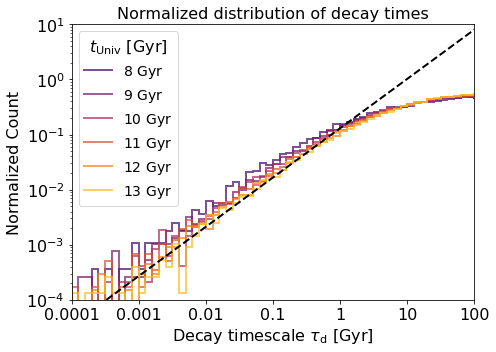

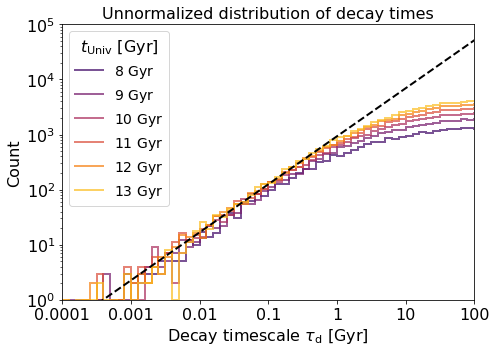

In [5]:
## PLOT DECAY TIMESCALE DISTRIBUTIONS 

##----------------------------------------------------------------------
## DENSITY NORMALIZED VERSION 

N_bins = 70
bin_range = (-4.5, 2.5)
cmap = matplotlib.cm.get_cmap('inferno')
colors = [cmap(i*0.13 + 0.2) for i in range(N_times_2)]
time_labels = [r'$' + str(int(t_arr[i])) + ' \ \mathrm{Gyr}$' for i in range(N_times_2+1)]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
for i in range(N_times_2):
    counts, bin_edges, _ = plt.hist(np.log10(tau_decay_evolve_arr_2[:,i+1]), bins = N_bins, range = bin_range, histtype = 'step', \
             density = True, color = colors[i], linewidth = 2, alpha = 0.7);
    # For legend
    plt.plot([100, 110], [0, 0], color = colors[i], linewidth = 2, alpha = 0.7, label = time_labels[i+1])
    
    
# linear fit
p_fit, residuals, sum_counts = linear_fit_function(tau_decay_evolve_arr_2, N_bins, time_threshold_low = 0.001, time_threshold_high = 1, bin_count_threshold = 10**-3.5, bin_range = bin_range, normalized = True)
print ('Normalized fit results: p_fit = ', p_fit)
print ('10^b = ', 10**p_fit[1])
x_values = np.linspace(-4.5, 2.5, 10) 
plt.plot(x_values, 10**(p_fit[0]*x_values + p_fit[1]), color = 'k', linestyle = '--', linewidth = 2)


plt.title('Normalized distribution of decay times', fontsize = 16)    
plt.xlabel('Decay timescale ' + r'$\tau_{\mathrm{d}} \ [\mathrm{Gyr}]$', fontsize = 16)
plt.ylabel('Normalized Count', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 16)
plt.legend(fontsize = 14, loc = 'upper left', title = r'$t_{\mathrm{Univ}} \ [\mathrm{Gyr}]$', title_fontsize = 16)
plt.yscale('log')
plt.ylim(10**(-4), 10**1)
plt.xlim(-4, 2.0)   
ax.set_xticks([-4, -3, -2, -1, 0, 1, 2])
ax.set_xticklabels([10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2)])

plt.tight_layout()




##----------------------------------------------------------------------
## NON-NORMALIZED VERSION 

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
for i in range(N_times_2): 
    counts, bin_edges, _ = plt.hist(np.log10(tau_decay_evolve_arr_2[:,i+1]), bins = N_bins, range = bin_range, histtype = 'step', \
             density = False, color = colors[i], linewidth = 2, alpha = 0.7)
    # For legend
    plt.plot([100, 110], [0, 0], color = colors[i], linewidth = 2, alpha = 0.7, label = time_labels[i+1])

# linear fit
p_fit, residuals, sum_counts = linear_fit_function(tau_decay_evolve_arr_2, N_bins, time_threshold_low = 0.0001, time_threshold_high = 1, bin_count_threshold = 1, bin_range = bin_range, normalized = False)
print ('Plots/Non-normalized fit results: p_fit = ', p_fit)
print ('10^b = ', 10**p_fit[1])
x_values = np.linspace(-4.5, 2.5, 10) 
plt.plot(x_values, 10**(p_fit[0]*x_values + p_fit[1]), color = 'k', linestyle = '--', linewidth = 2)


plt.title('Unnormalized distribution of decay times', fontsize = 16)    
plt.xlabel('Decay timescale ' + r'$\tau_{\mathrm{d}} \ [\mathrm{Gyr}]$', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 16)
plt.legend(fontsize = 14, loc = 'upper left', title = r'$t_{\mathrm{Univ}} \ [\mathrm{Gyr}]$', title_fontsize = 16)
plt.yscale('log')
plt.ylim(1, 10**5) 
plt.xlim(-4, 2.0)  
ax.set_xticks([-4, -3, -2, -1, 0, 1, 2])
ax.set_xticklabels([10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2)])

plt.tight_layout()

